In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def compute_daily_yield(data):
    if data.empty:
        return pd.Series(dtype=float)
    total_orig = data.groupby("LoanID")["OriginatedAmount"].first().sum()
    daily_paid = data.groupby("Days_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
    return daily_paid / total_orig

In [5]:
latest = pd.read_csv("/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/yieldcurvedata_1007.csv")
july = pd.read_csv("/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/yieldcurvedata_730.csv")
august = pd.read_csv("/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/yieldcurvedata_820.csv")

In [6]:
def preprocess_data(df, name):
    """Preprocess yield curve data"""
    df = df.copy()
    df["OriginationDate"] = pd.to_datetime(df["OriginationDate"])
    df = df.dropna(subset=["Days_Since_Orig", "OriginatedAmount", "PaidOffPaymentAmount", "Frequency"])
    df = df[df["PaymentStatus"] == "D"]
    df["Days_Since_Orig"] = df["Days_Since_Orig"].astype(int)
    df["OrigMonth"] = df["OriginationDate"].dt.to_period("M")
    print(f"{name} data: {len(df)} records, {df['LoanID'].nunique()} unique loans")
    return df

latest = preprocess_data(latest, "Latest")
july = preprocess_data(july, "July") 
august = preprocess_data(august, "August")

Latest data: 437613 records, 92958 unique loans
July data: 388277 records, 83927 unique loans
August data: 404144 records, 87045 unique loans


In [7]:
months_analysis = {
    '2024 Nov': [pd.Period('2024-11')],
    '2024 Dec': [pd.Period('2024-12')],
    '2025 Jan': [pd.Period('2025-01')],
    '2025 Feb': [pd.Period('2025-02')],
    '2025 Mar': [pd.Period('2025-03')],
    '2025 Apr': [pd.Period('2025-04')],
    '2025 May': [pd.Period('2025-05')],
    '2025 Jun': [pd.Period('2025-06')],
    '2025 Jul': [pd.Period('2025-07')],
    '2025 Aug': [pd.Period('2025-08')],
}

# Function to get monthly data
def get_monthly_data(df, months_list):
    return df[df['OrigMonth'].isin(months_list)]

# Colors for each month
month_colors = {
    '2024 Nov': 'black',
    '2024 Dec': 'blue',
    '2025 Jan': 'green',
    '2025 Feb': 'red',
    '2025 Mar': 'grey',
    '2025 Apr': 'orange',
    '2025 May': 'yellow',
    '2025 Jun': 'brown',
    '2025 Jul': 'purple',
    '2025 Aug': 'pink'
}

In [ ]:
# Filter latest to January 2025 and show size (reuses your helpers)
jan_2025 = get_monthly_data(latest, months_analysis['2025 Jan'])
print(jan_2025.shape)  # expected: (21559, 26)
print(jan_2025.columns)

(21559, 25)
Index(['Application_ID', 'PortFolioID', 'LoanID', 'Frequency', 'LPCampaign',
       'OriginatedAmount', 'OrigYear', 'OrigMonth', 'OrigWeek',
       'OriginationDate', 'FPDFA', 'FPDAA', 'TotalRealizedPayin',
       'InstallmentNumber', 'PaidOffPaymentAmount', 'TransactionDate',
       'PmtYear', 'PmtMonth', 'Days_Since_Orig', 'Weeks_Since_Orig',
       'PaymentType', 'Payment_Number', 'PaymentStatus',
       'weeks_between_orig_now', 'CustType'],
      dtype='object')


In [10]:
jan_2025['PaymentType'].value_counts()

PaymentType
Installment Pmt    17472
Z                   1913
Arr Pmt              751
Reset Pmt            725
Partial Pmt          496
Delinquent Pmt       128
3rd Party Pmt         74
Name: count, dtype: int64

In [20]:
# Import external Excel and join with jan_2025 on Application ID
excel_path = "/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/2025jan_yield.xlsx"
external_df = pd.read_excel(excel_path)

# Determine right-side key name flexibly
if "ApplicationID" in external_df.columns:
    right_key = "ApplicationID"
elif "Application_Id" in external_df.columns:
    right_key = "Application_Id"
elif "Application_ID" in external_df.columns:
    right_key = "Application_ID"
else:
    raise KeyError(f"Application ID column not found in external file. Columns: {list(external_df.columns)}")
# Deduplicate by Application ID on both sides and re-merge to avoid many-to-many
# Inspect duplicates
jan_dups = jan_2025.duplicated(subset=["Application_ID"]).sum()
ext_dups = external_df.duplicated(subset=[right_key]).sum()
print(f"jan_2025 duplicate Application_IDs: {jan_dups}")
print(f"external duplicate {right_key}s: {ext_dups}")

jan_2025 duplicate Application_IDs: 17158
external duplicate ApplicationIDs: 10


In [21]:

# Create unique-per-application views (keep first occurrence)
jan_2025_unique = jan_2025.drop_duplicates(subset=["Application_ID"], keep="first").copy()
external_unique = external_df.drop_duplicates(subset=[right_key], keep="first").copy()

# Coerce join keys to common type to be safe
jan_2025_unique["Application_ID"] = jan_2025_unique["Application_ID"].astype(str)
external_unique[right_key] = external_unique[right_key].astype(str)

# Re-merge to get a unique-per-application merged table
merged_jan_2025_unique = jan_2025_unique.merge(
    external_unique,
    left_on="Application_ID",
    right_on=right_key,
    how="right",
    suffixes=("", "_ext")
)

print("jan_2025_unique rows:", len(jan_2025_unique))
print("external_unique rows:", len(external_unique))
print("merged_jan_2025_unique shape:", merged_jan_2025_unique.shape)
print("matched unique apps:", merged_jan_2025_unique[right_key].notna().sum())


jan_2025_unique rows: 4401
external_unique rows: 588
merged_jan_2025_unique shape: (588, 70)
matched unique apps: 588


In [23]:
merged_jan_2025_unique['Frequency'].value_counts()

Frequency
W     429
B      99
ME      1
Name: count, dtype: int64

In [26]:
# Helper: build non-cumulative installment payin curve for a subset
# Returns: (curve_df, loan_count, per_installment_df)
# - curve_df columns: ['InstallmentNumber','PayinRatio'] (weighted by OriginatedAmount)
# - per_installment_df columns include per-loan PaidThisInstallment and InstallmentPayinRatio

def build_installment_non_cum_curve(df_sub: pd.DataFrame, cap: float = 1.75):
    if df_sub.empty:
        return pd.DataFrame(columns=['InstallmentNumber','PayinRatio']), 0, pd.DataFrame()

    loan_count = df_sub['LoanID'].nunique()

    per_inst = (df_sub.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                   .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                        OriginatedAmount=('OriginatedAmount', 'first')))

    per_inst['InstallmentPayinRatio'] = (
        per_inst['PaidThisInstallment'] / per_inst['OriginatedAmount']
    ).clip(upper=cap)

    # Weighted average without groupby.apply (avoid FutureWarning)
    per_inst['weighted'] = per_inst['InstallmentPayinRatio'] * per_inst['OriginatedAmount']
    curve = (per_inst.groupby('InstallmentNumber', as_index=False)
                    .agg(weighted_payin=('weighted', 'sum'), total_orig=('OriginatedAmount', 'sum')))
    curve['PayinRatio'] = curve['weighted_payin'] / curve['total_orig']
    curve = curve[['InstallmentNumber', 'PayinRatio']].sort_values('InstallmentNumber').reset_index(drop=True)

    return curve, loan_count, per_inst


### Sanity Check (standalone run)

In [33]:
merged_jan_2025_unique['LoanID'].nunique()
per_inst = (merged_jan_2025_unique.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                   .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                        OriginatedAmount=('OriginatedAmount', 'first')))
per_inst['InstallmentPayinRatio'] = (
        per_inst['PaidThisInstallment'] / per_inst['OriginatedAmount']
    )
per_inst['weighted'] = per_inst['InstallmentPayinRatio'] * per_inst['OriginatedAmount']
curve = (per_inst.groupby('InstallmentNumber', as_index=False)
                    .agg(weighted_payin=('weighted', 'sum'), total_orig=('OriginatedAmount', 'sum')))
curve['PayinRatio'] = curve['weighted_payin'] / curve['total_orig']
curve = curve[['InstallmentNumber', 'PayinRatio']].sort_values('InstallmentNumber').reset_index(drop=True)

In [35]:
per_inst.head(10)

,LoanID,InstallmentNumber,PaidThisInstallment,OriginatedAmount,InstallmentPayinRatio,weighted
0,I2222172-0,1.0,65.00,700.0,0.092857,65.00
1,I2222186-0,2.0,222.86,200.0,1.114300,222.86
2,I2222214-0,1.0,15.00,200.0,0.075000,15.00
3,I2222228-0,2.0,80.00,400.0,0.200000,80.00
4,I2222235-0,1.0,225.00,1500.0,0.150000,225.00
5,I2222239-0,1.0,691.25,650.0,1.063462,691.25
6,I2222248-0,1.0,200.00,1000.0,0.200000,200.00
7,I2222346-0,1.0,125.00,1500.0,0.083333,125.00
8,I2222410-0,1.0,125.00,1500.0,0.083333,125.00
9,I2222513-0,2.0,80.00,400.0,0.200000,80.00


### Plottig portion, run after sanity check

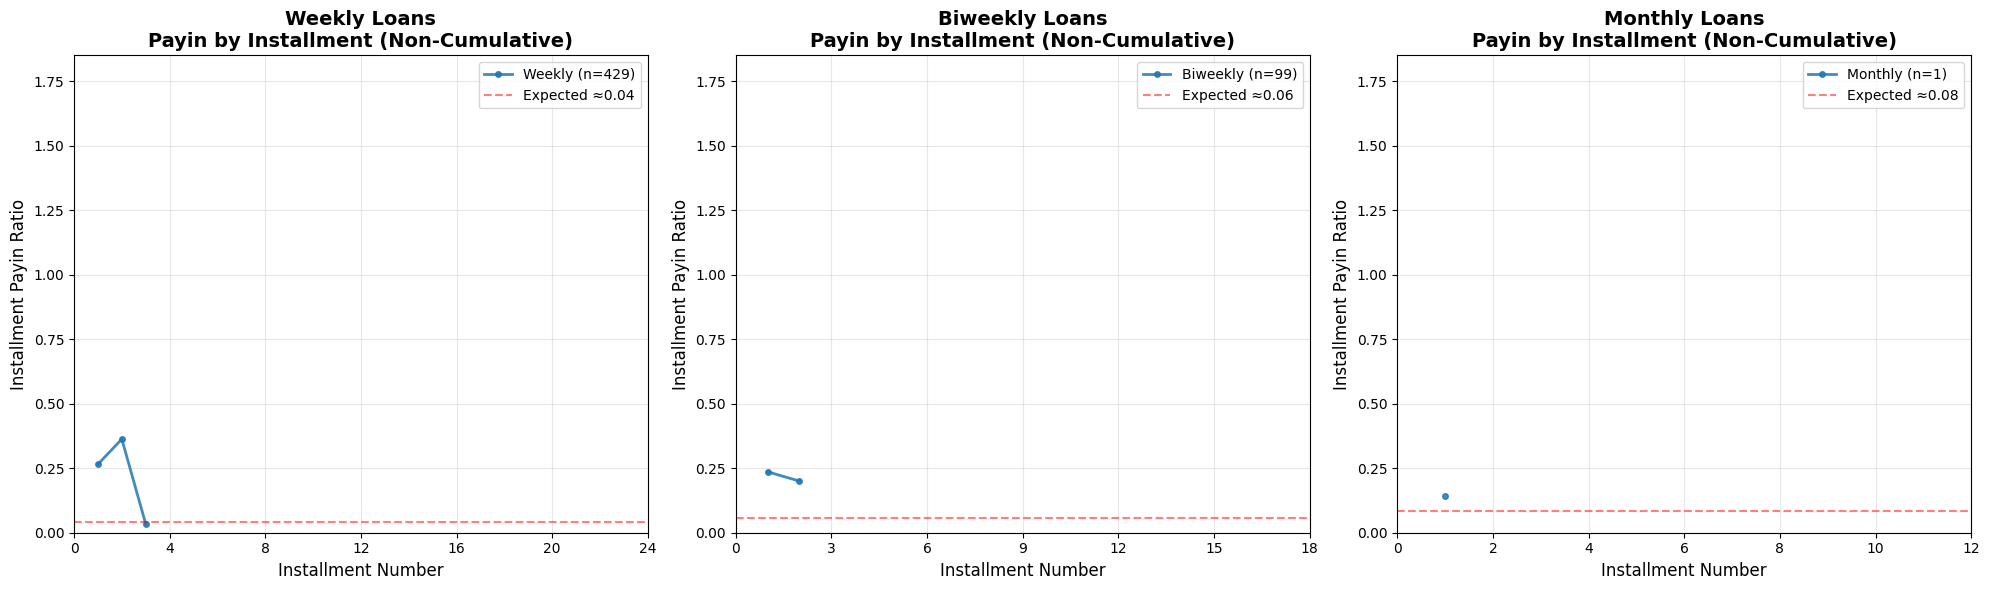

In [27]:
# Payin by Installment (Non-Cumulative) — Weekly, Biweekly, Monthly (MB+ME)
freq_groups = {
    'Weekly': ['W'],
    'Biweekly': ['B'],
    'Monthly': ['MB', 'ME'],
}
cap = 1.75

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for idx, (title, codes) in enumerate(freq_groups.items()):
    ax = axes[idx]
    sub = merged_jan_2025_unique[merged_jan_2025_unique['Frequency'].isin(codes)].copy()

    if sub.empty:
        ax.set_title(f'{title} Loans — No data')
        ax.axis('off')
        continue

    # Use helper to build curve and loan count
    curve, loan_count, per_inst = build_installment_non_cum_curve(sub, cap=cap)

    # Plot
    ax.plot(curve['InstallmentNumber'], curve['PayinRatio'],
            color='C0', linewidth=2, marker='o', markersize=4,
            label=f'{title} (n={loan_count:,})', alpha=0.85)

    ax.set_xlabel('Installment Number', fontsize=12)
    ax.set_ylabel('Installment Payin Ratio', fontsize=12)
    ax.set_title(f'{title} Loans\nPayin by Installment (Non-Cumulative)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    if title == 'Weekly':
        max_installment = 24
    elif title == 'Biweekly':
        max_installment = 18
    else:
        max_installment = 12

    ax.set_xlim(0, max_installment)
    ax.set_ylim(0.0, cap + 0.1)

    expected = 1.0 / max_installment
    ax.axhline(y=expected, color='red', linestyle='--', alpha=0.5, label=f'Expected ≈{expected:.2f}')

    if title == 'Weekly':
        ax.set_xticks(range(0, max_installment + 1, 4))
    elif title == 'Biweekly':
        ax.set_xticks(range(0, max_installment + 1, 3))
    else:
        ax.set_xticks(range(0, max_installment + 1, 2))

    ax.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()
